In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/mnt/experiments/correlation_GAN/')

In [34]:
from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from utils.constants import DATA_DIR, OUTPUTS_DIR, FIGURES_DIR
from utils.generic import load_data_config, load_cleaned_dataset, load_generated_data, load_model_config, load_pkl
from data.preprocess import MultiColumnLabelEncoder

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.set_context('paper')

## Impact of non-uniform correlations on generation

In [4]:
model1 = 'dcgan'
model2 = 'tablegan'
dataset_name = 'dataset_4'
data_type = 'synthetic'

In [6]:
data_config = load_data_config(dataset_name=dataset_name, data_type=data_type)
data = load_cleaned_dataset(dataset_name=dataset_name, data_type=data_type)

In [8]:
def get_model_generated_data(model_version, data_type, dataset_name):
    model_config = load_model_config(model_version)
    saved_outputs_dir = join(OUTPUTS_DIR, data_type, dataset_name, model_version)
    generated_outputs = load_pkl(join(saved_outputs_dir, 'generated_kfold.pkl'))
    
    return generated_outputs

In [9]:
dcgan_generated_outputs = get_model_generated_data(model1, data_type, dataset_name)

In [10]:
tgan_generated_outputs = get_model_generated_data(model2, data_type, dataset_name)

In [12]:
dcgan_generated_outputs.keys(), data.keys()

(dict_keys(['1', '2', '3', '4']), dict_keys(['1', '2', '3', '4']))

In [14]:
dcgan_generated_outputs['1']['fold-1'].keys(), data['1'].keys()

(dict_keys(['original', 'generated', 'test']),
 dict_keys(['northwest', 'southeast', 'rest', 'data', 'seed', 'C_in', 'C_sim']))

In [21]:
dcgan_generated_outputs['1']['fold-1']['test'][0]

array([0.56111191, 0.4892962 , 0.28698488, 0.29009031, 0.42109531,
       0.3784524 , 0.30487031, 0.36163982, 0.29640168, 0.39333278])

### Comparing through Euclidean distances

In [11]:
def compute_distance(original, generated, subspace_columns, num_real):
    
    all_columns = list(original.columns)
    real_columns = [x for i, x in enumerate(all_columns) if i < num_real]
    cat_columns = [x for i, x in enumerate(all_columns) if i >= num_real]

    mle = MultiColumnLabelEncoder(cat_columns)
    mle.fit(pd.concat([original, generated]))
    original = mle.transform(original)
    generated = mle.transform(generated)

    scaler = StandardScaler()
    scaler.fit(pd.concat([original, generated]).values)
    original = scaler.transform(original)
    generated = scaler.transform(generated)
    
    subspace_indices = [all_columns.index(x) for x in subspace_columns]
    original_subset = original[:, subspace_indices]
    generated_subset = generated[:, subspace_indices]
    
    nbrs = NearestNeighbors(n_neighbors=1)
    nbrs.fit(generated_subset)
    dist, idx = nbrs.kneighbors(original_subset)
    
    closest = generated[idx.reshape(-1)]

    dist = (original - closest) ** 2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)
    
    return np.mean(dist), np.std(dist)

In [29]:
def get_original_data_for_given_fold(original_data, fold, num_folds=10):

    total_examples = original_data.shape[0]
    test_set_size = total_examples // num_folds

    split_index = int(fold.split('-')[-1])

    start, end = (split_index - 1) * test_set_size, split_index * test_set_size
    
    X_test = original_data.iloc[start:end, :]
    X_train = pd.concat([original_data.iloc[:start, :], original_data.iloc[end:, :]])
    
    return X_train, X_test

In [32]:
cases = list(data.keys())

In [57]:
for model in ['DCGAN', 'Table GAN']:
    print("=> Distances for model: {}".format(model))
    generated_outputs = dcgan_generated_outputs if model == 'DCGAN' else tgan_generated_outputs

    for case in cases:
        print("==> Case {}".format(case))
        original_data = data[case]['data']
        distances = []
        folds = list(generated_outputs[case].keys())

        for fold in folds:
            generated_data = generated_outputs[case][fold]['generated']
            original_data_train, original_data_test = get_original_data_for_given_fold(original_data, fold)

            subspace_columns = data_config['QIDs'] + [data_config['sensitive']]
            num_real = data_config['num_real']
            dist, _ = compute_distance(original_data_train, generated_data, subspace_columns, num_real)
            distances.append(dist)
    
        print(np.mean(distances), np.std(distances))

=> Distances for model: DCGAN
==> Case 1
2.7549897818747064 0.29287381896072767
==> Case 2
2.8432251976445797 0.40199904268790765
==> Case 3
2.700879492516168 0.532662956020056
==> Case 4
2.753491056117662 0.2351637780179274
=> Distances for model: Table GAN
==> Case 1
3.2684078583220284 0.22483911858573777
==> Case 2
3.4262335740321945 0.18685733533177076
==> Case 3
3.170199802684877 0.3633162656708086
==> Case 4
3.4238503487402943 0.18857462915217746


### Comparing distributions through CDF

In [42]:
def plot_cdf(original, dcgan_generated, tgan_generated, features_to_plot):

    kwargs = {'cumulative': True, "linewidth": 2.5}
    
    if len(features_to_plot) <= 5:
        nrows, ncols = 1, len(features_to_plot)
    else:
        assert len(features_to_plot) % 2 == 0
        nrows, ncols = 2, len(features_to_plot) // 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, 4 * nrows))
    
    fig.suptitle('Feature-wise CDF for original and generated data', fontsize=16)

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            feature = features_to_plot[index]
            
            ax = axes[j] if nrows == 1 else axes[i][j]
            
            labels = [None, None, None]
            if i == nrows - 1 and j == 2:
                spl_ax = ax
                labels = ['Original', 'DCGAN', 'table-GAN']

            l1 = sns.distplot(original[feature].values, hist_kws=kwargs, kde_kws=kwargs,
                         ax=ax, hist=False, label=labels[0], axlabel=False)
            l2 = sns.distplot(dcgan_generated[feature].values, hist_kws=kwargs, kde_kws=kwargs,
                         ax=ax, hist=False, label=labels[1], axlabel=False)
            l3 = sns.distplot(tgan_generated[feature].values, hist_kws=kwargs, kde_kws=kwargs,
                         ax=ax, hist=False, label=labels[2], axlabel=False)
            ax.set_title('{}'.format(feature))
            ax.grid()
            
            if i == nrows - 1:
                ax.set_xlabel(r'$x$')
            if j == 0:
                ax.set_ylabel('Probability')
            
    
    handles, labels = spl_ax.get_legend_handles_labels()
    lgd = spl_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=3, prop={'size': 15})
    plt.show()

### Comparing correlation structure

In [48]:
def plot_correlations(data1, data2, data3):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    sns.heatmap(data1, vmin=0.0, vmax=1.0, ax=ax1, cmap=cmap)
    ax1.set_title("Correlation of original data")
    sns.heatmap(data2, vmin=0.0, vmax=1.0, ax=ax2, cmap=cmap)
    ax2.set_title("Correlation with DCGAN")
    sns.heatmap(data3, vmin=0.0, vmax=1.0, ax=ax3, cmap=cmap)
    ax3.set_title("Correlation with tableGAN")

    plt.show()

In [49]:
def plot_frobenius_comparison(overall, top, bottom, rest):
    norms = ['F(Original, DCGAN)', 'F(Original, table-GAN)']
    labels = ['Overall', 'Top part', 'Bottom part', 'Rest of the matrix']

    dcgan = np.array([overall[norms[0]], top[norms[0]], bottom[norms[0]], rest[norms[0]]])
    dcgan = np.round(dcgan, 2)
    tablegan = np.array([overall[norms[1]], top[norms[1]], bottom[norms[1]], rest[norms[1]]])
    tablegan = np.round(tablegan, 2)

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, dcgan, width, label=norms[0])
    rects2 = ax.bar(x + width/2, tablegan, width, label=norms[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(r'Frobenius ($L_{2}$) norm', fontsize=11)
    ax.set_title('Comparison of Frobenius distance between correlations', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontdict={'size': 12})
    ax.legend(fontsize=12, loc='upper center')
    ax.grid()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11)

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

In [50]:
def frobenius(matrix_a, matrix_b):
    return np.linalg.norm(matrix_a - matrix_b, ord=2)

def get_rest_of_matrix_frobenius(matrix1, matrix2, subset_marker=4):
    matrix1.iloc[:subset_marker, :subset_marker] = 0
    matrix1.iloc[-subset_marker:, -subset_marker:] = 0
    matrix2.iloc[:subset_marker, :subset_marker] = 0
    matrix2.iloc[-subset_marker:, -subset_marker:] = 0
    
    # dividing by 4 because it is roughly 4 times the size of top/bottom
    return frobenius(matrix1, matrix2) / 4

def get_top_of_matrix_frobenius(matrix1, matrix2, subset_marker=4):
    return frobenius(matrix1.iloc[:subset_marker, :subset_marker], matrix2.iloc[:subset_marker, :subset_marker])

def get_bottom_of_matrix_frobenius(matrix1, matrix2, subset_marker=4):
    return frobenius(matrix1.iloc[-subset_marker:, -subset_marker:], matrix2.iloc[-subset_marker:, -subset_marker:])

def compare_frobenius_norm(corr1, corr2, corr3, subset_marker=4):

    overall = {
        'F(Original, DCGAN)': frobenius(corr1, corr2), 
        'F(Original, table-GAN)': frobenius(corr1, corr3)
    }
    
    top = {
        'F(Original, DCGAN)': get_top_of_matrix_frobenius(corr1, corr2),
        'F(Original, table-GAN)': get_top_of_matrix_frobenius(corr1, corr3)
    }

    bottom = {
        'F(Original, DCGAN)': get_bottom_of_matrix_frobenius(corr1, corr2),
        'F(Original, table-GAN)': get_bottom_of_matrix_frobenius(corr1, corr3)
    }
    
    rest = {
        'F(Original, DCGAN)': get_rest_of_matrix_frobenius(corr1, corr2),
        'F(Original, table-GAN)': get_rest_of_matrix_frobenius(corr1, corr3)
    }
    
    plot_frobenius_comparison(overall, top, bottom, rest)

Case: 1


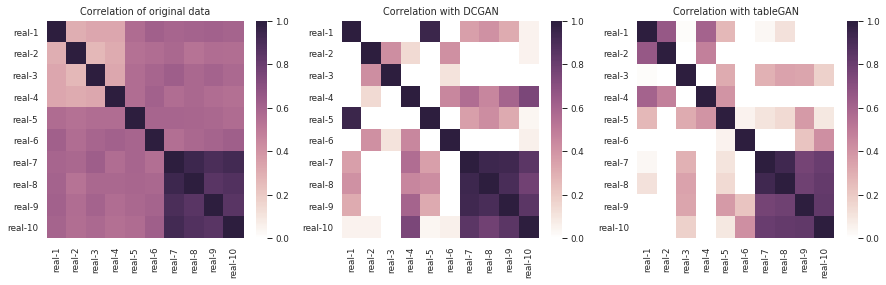

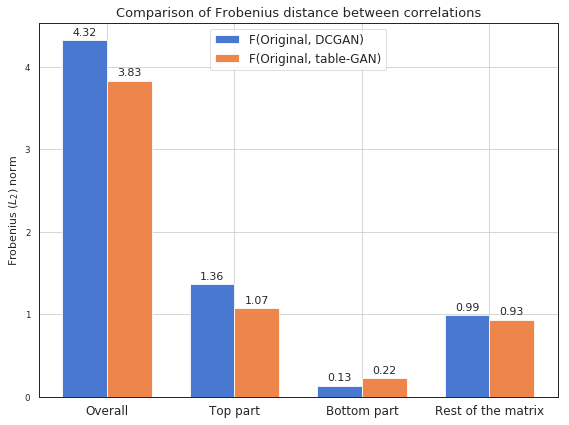

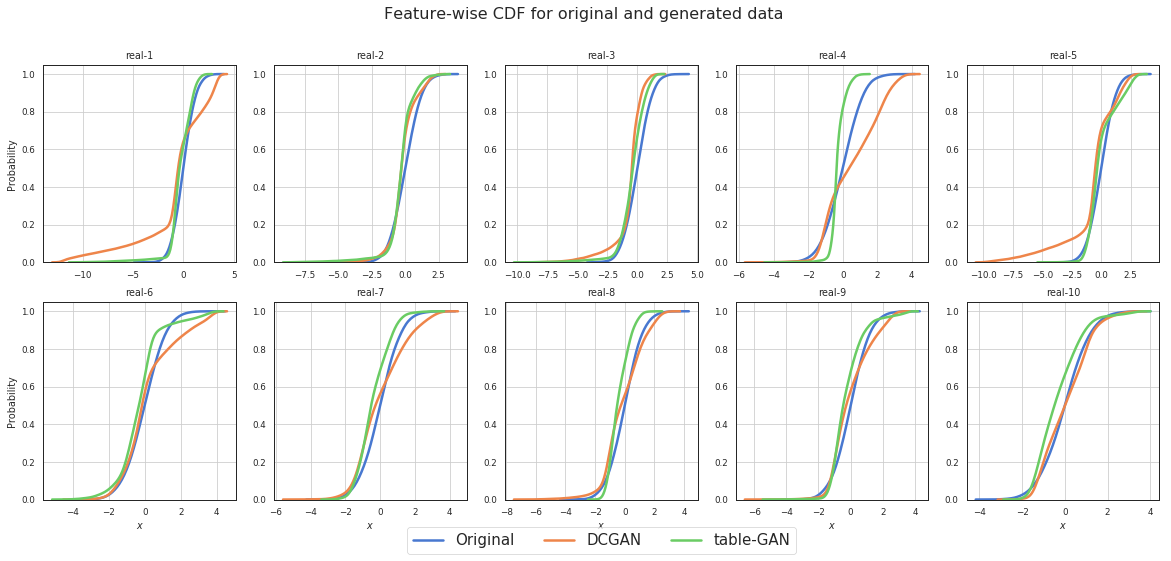

Case: 2


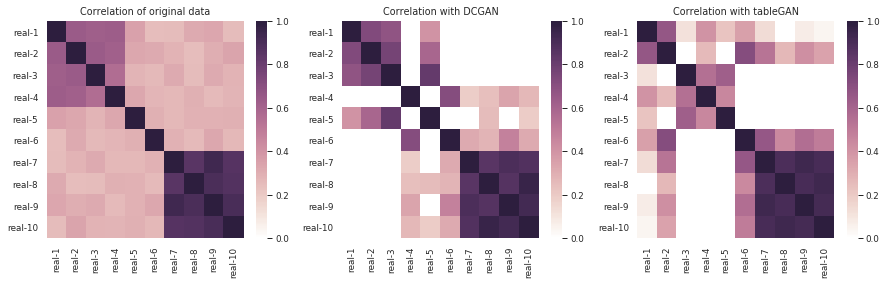

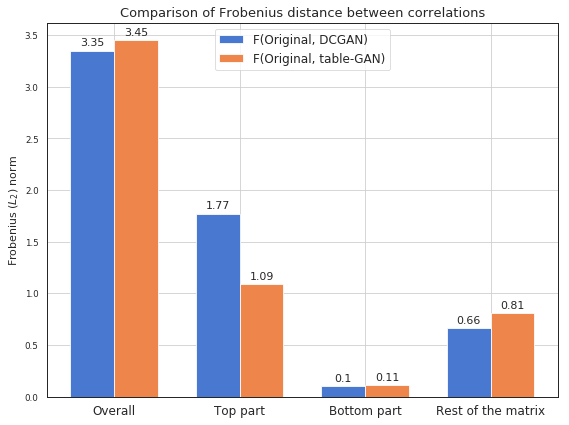

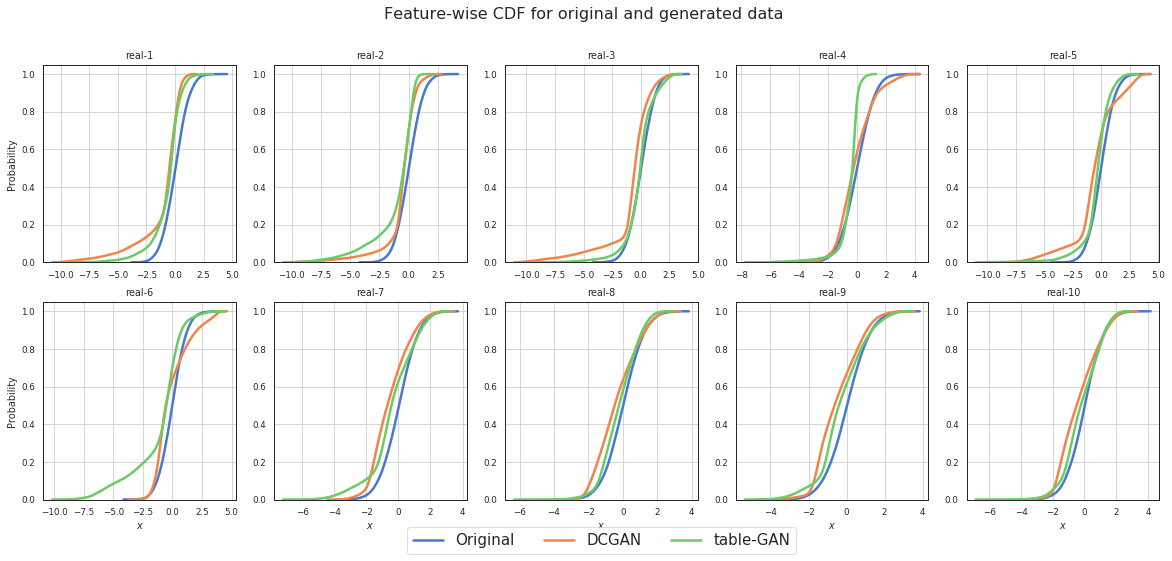

Case: 3


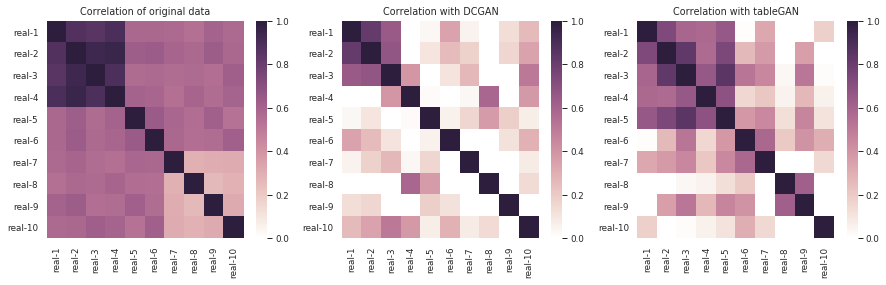

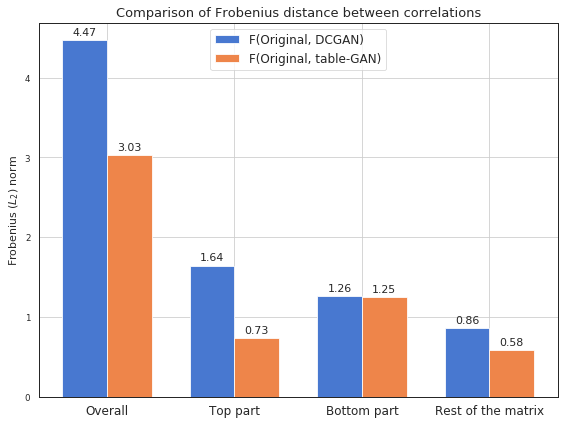

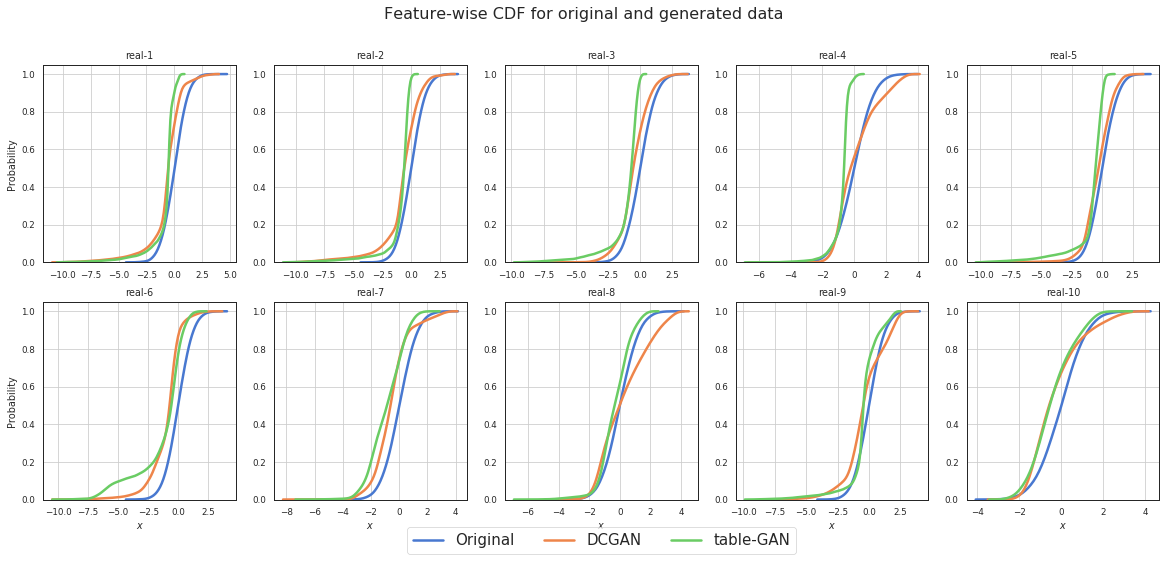

Case: 4


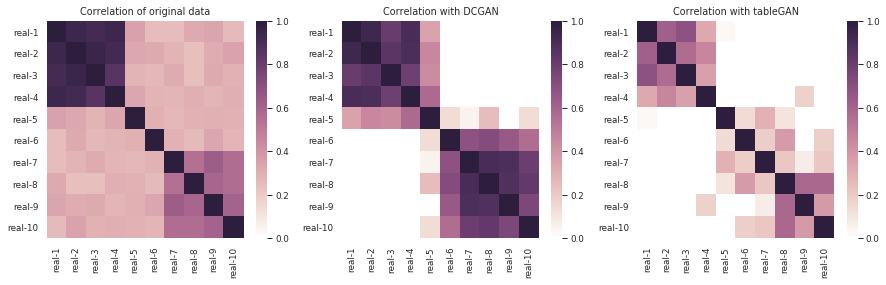

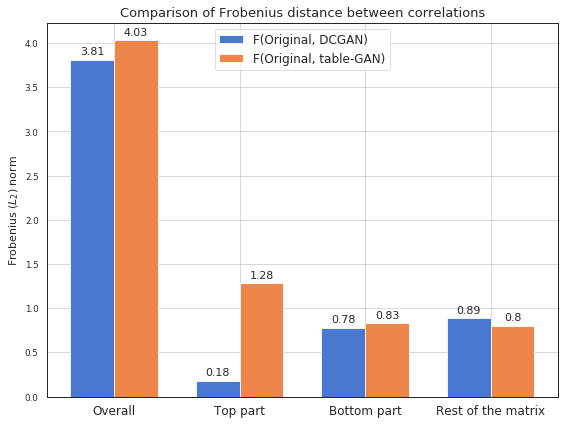

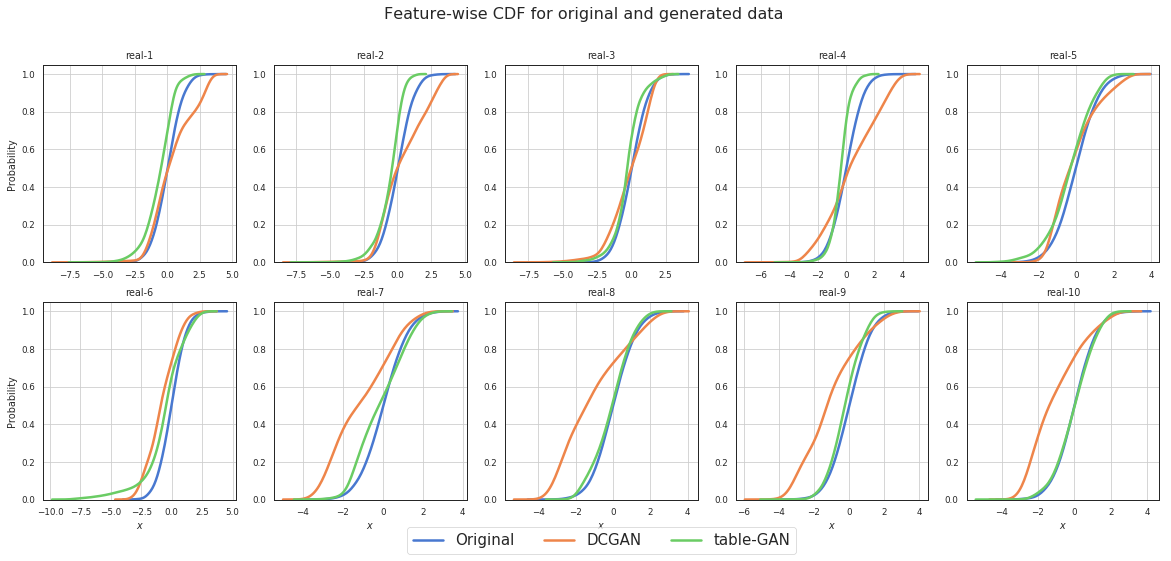

In [58]:
for case in cases:
    print("Case: {}".format(case))
    
    original_data = data[case]['data']
    dcgan_generated_data = dcgan_generated_outputs[case]['fold-1']['generated']
    tgan_generated_data = tgan_generated_outputs[case]['fold-1']['generated']
    
    corr1, corr2, corr3 = original_data.corr(), dcgan_generated_data.corr(), tgan_generated_data.corr()
    
    plot_correlations(corr1, corr2, corr3)
    compare_frobenius_norm(corr1, corr2, corr3)
    plot_cdf(original_data, dcgan_generated_data, tgan_generated_data, features_to_plot=list(original_data.columns))

#### Points to note

1. In terms of comparison of genration, using individual featurewise distributions, it is not clear if DCGAN is better or worse than table GAN
2. Again in terms of correlation preservation, if you look at it from overall Frobenius distance, no one model is better. However, when you look at fine-grained Frobenius, we observe:
    a. High Correlation case: Very good preservation compared to the other cases for both models, slightly better for DCGAN as compared to privacy-table GAN. We can say not either of them can achieve both privacy and utility. Since in privacy-utility , we need some correlations to be preserved and some to be destroyed.

* Q. Does the same pattern repeat in the categorical data cases?
* Q. What happens when we use negative correlations?
* Q. What happens with real world datasets (Adult, LA City, --)?
* Q. If in real datasets we observe most correlations are low, should we focus more on the low correlation case?

## Impact of Label Encoding on Generation

In [174]:
dcgan_version = 'dcgan'
tgan_version = 'tablegan'
dataset_name = 'dataset_6'
data_type = 'synthetic'

In [175]:
data_config = load_data_config(dataset_name=dataset_name, data_type=data_type)
model_config = load_model_config(model_version)
data = load_cleaned_dataset(dataset_name=dataset_name, data_type=data_type)

dcgan_saved_outputs_dir = join(OUTPUTS_DIR, data_type, dataset_name, dcgan_version)
tgan_saved_outputs_dir = join(OUTPUTS_DIR, data_type, dataset_name, tgan_version)

In [176]:
dcgan_generated_outputs = load_pkl(join(dcgan_saved_outputs_dir, 'generated.pkl'))
tgan_generated_outputs = load_pkl(join(tgan_saved_outputs_dir, 'generated.pkl'))

In [177]:
dcgan_generated_outputs['random'].keys()

dict_keys(['data'])

In [178]:
data['random'].keys()

dict_keys(['data', 'order'])

### Comparing correlations

In [179]:
def update_correlations(original, dcgan_generated, tgan_generated):
    raw_keys = np.array(list(original.keys())).copy()
    for key in raw_keys:
        original['corr'] = original[key]['data'].corr()
        dcgan_generated['corr'] = dcgan_generated[key]['data'].corr()
        tgan_generated['corr'] = tgan_generated[key]['data'].corr()
    return original, dcgan_generated, tgan_generated

In [194]:
def label_encode(data):
    cat_columns = [x for x in data.columns if x.startswith('cat')]
    mle = MultiColumnLabelEncoder(cat_columns)
    
    return mle.fit_transform(data).astype(float)

In [180]:
data, dcgan_generated_outputs, tgan_generated_outputs = update_correlations(data, dcgan_generated_outputs, tgan_generated_outputs)

In [185]:
data.keys()

dict_keys(['random', 'sorted', 'inverse sorted', 'corr'])

In [183]:
data['random'].keys()

dict_keys(['data', 'order'])

In [186]:
data['random']['data'].head()

,real-1,real-2,cat-1,cat-2
0,6.41013,0.309724,h,q
1,3.00039,-0.737456,h,q
2,4.44684,-1.53692,h,q
3,7.60223,-0.562255,h,q
4,6.66889,-1.59951,h,q


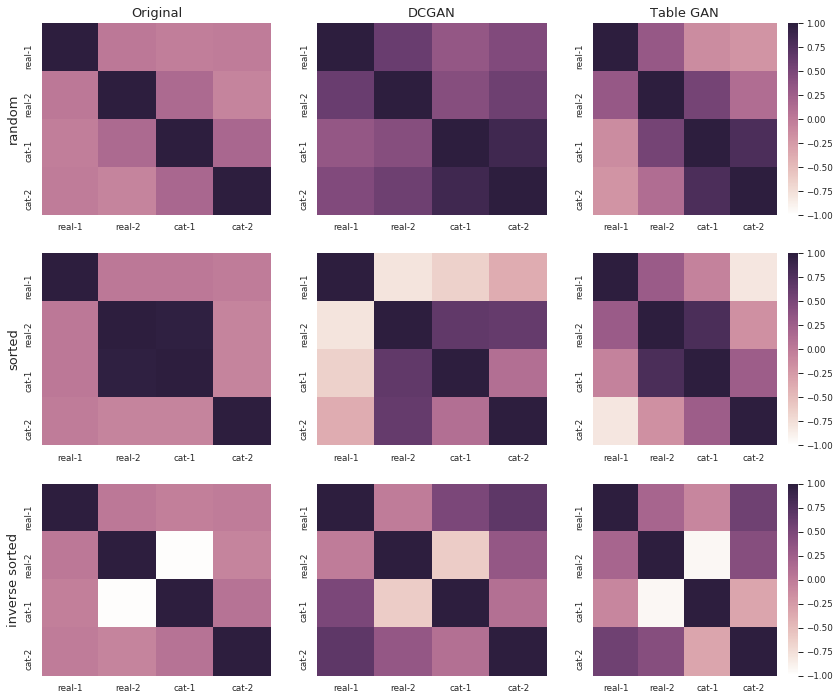

In [244]:
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 12))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

orders = ['random', 'sorted', 'inverse sorted']
data_sources = ['Original', 'DCGAN', 'Table GAN']

for i in range(nrows):
    ax = axes[i][0]
    X = label_encode(data[orders[i]]['data'])
    sns.heatmap(X.corr(), vmin=-1.0, vmax=1.0, ax=ax, cmap=cmap, cbar=False)
    if i == 0:
        ax.set_title(data_sources[0], fontsize=13)
    ax.set_ylabel(orders[i], fontsize=13)

    ax = axes[i][1]
    X = label_encode(dcgan_generated_outputs[orders[i]]['data'])
    sns.heatmap(X.corr(), vmin=-1.0, vmax=1.0, ax=ax, cmap=cmap, cbar=False)
    if i == 0:
        ax.set_title(data_sources[1], fontsize=13)

    ax = axes[i][2]
    X = label_encode(tgan_generated_outputs[orders[i]]['data'])
    sns.heatmap(X.corr(), vmin=-1.0, vmax=1.0, ax=ax, cmap=cmap, cbar=True)
    if i == 0:
        ax.set_title(data_sources[2], fontsize=13)

plt.savefig(join(FIGURES_DIR, 'label_encoding_on_correlation.png'), bbox_inches='tight')
plt.show()

In [232]:
Z = {'Frobenius norm':[], 'Model':[], 'Label Encoding Order':[]}
models = ['DCGAN', 'Table GAN']
orders = ['random', 'sorted', 'inverse sorted']

for model in models:
    for order in orders:
        X1 = label_encode(data[order]['data']).corr()
        generated = dcgan_generated_outputs if 'DCGAN' in model else tgan_generated_outputs
        X2 = label_encode(generated[order]['data']).corr()
        norm = frobenius(X1, X2)
        
        Z['Frobenius norm'].append(norm)
        Z['Model'].append(model)
        Z['Label Encoding Order'].append(order)

Z = pd.DataFrame(Z);
Z

,Frobenius norm,Model,Label Encoding Order
0,1.529989,DCGAN,random
1,1.332116,DCGAN,sorted
2,1.028222,DCGAN,inverse sorted
3,0.815208,Table GAN,random
4,0.984793,Table GAN,sorted
5,0.940524,Table GAN,inverse sorted


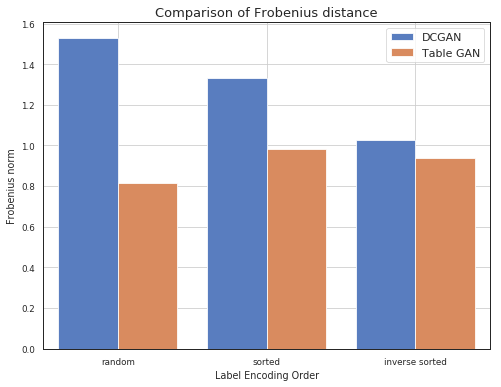

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(x="Label Encoding Order", y="Frobenius norm", hue="Model", data=Z, ax=ax)
ax.grid()
ax.set_title("Comparison of Frobenius distance", fontdict={'size': 13})
ax.legend(fontsize=11)

plt.savefig(join(FIGURES_DIR, 'label_encoding_frobenius.png'), bbox_inches='tight')
plt.show()

### Comparing data distributions

In [251]:
def visualize_data_distribution(real_columns=['real-1', 'real-2'], cat_columns=['cat-1', 'cat-2']):
    
    orders = ['random', 'sorted', 'inverse sorted']
    total_rows = len(orders)
    total_cols = len(real_columns) + len(cat_columns)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
    
    for i, order in enumerate(orders):

        for j, col in enumerate(real_columns):

#             ax = fig.add_subplot(gs[i][j])
            ax = axes[i][j]

#             labels = [None, None, None]
#             if i == nrows - 1 and j == 2:
#                 spl_ax = ax
            labels = ['Original', 'DCGAN', 'table-GAN']

            
            kwargs = {'cumulative': True}
            l1 = sns.distplot(data[order]['data'][col].values, hist_kws=kwargs, kde_kws=kwargs,
                         ax=ax, hist=False, label=labels[0], axlabel=False)
            l2 = sns.distplot(dcgan_generated_outputs[order]['data'][col].values, hist_kws=kwargs, kde_kws=kwargs,
                         ax=ax, hist=False, label=labels[1], axlabel=False)
            l3 = sns.distplot(tgan_generated_outputs[order]['data'][col].values, hist_kws=kwargs, kde_kws=kwargs,
                         ax=ax, hist=False, label=labels[2], axlabel=False)
            ax.set_title('{}'.format(order))
            ax.set_xlabel(col, fontsize=13)
            ax.grid()

        for j, col in enumerate(cat_columns):

            ax = axes[i][len(real_columns) + j]

            sns.countplot(x=col, data=data[order]['data'], ax=ax)
            ax.grid()
            ax.set_ylabel('')
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
            ax.set_xlabel(ax.get_xlabel(), fontsize=13)

    plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

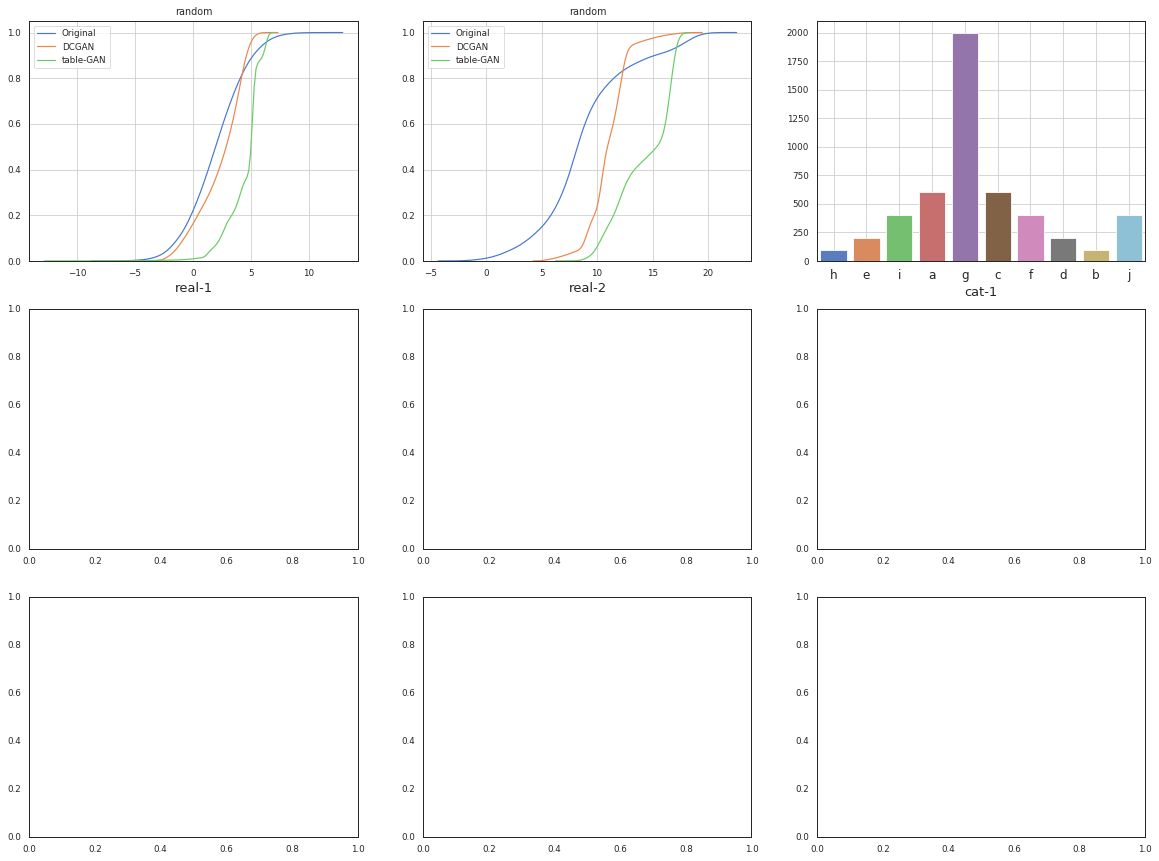

In [252]:
visualize_data_distribution()

## 2D data

In [95]:
def colored_scatter(x, y, c=None, alpha=0.7, marker='o', s=20):
    def scatter(*args, **kwargs):
        args = (x, y)
        if c is not None:
            kwargs['c'] = c
        kwargs['alpha'] = alpha
        kwargs['marker'] = marker
        kwargs['s'] = s
        plt.scatter(*args, **kwargs)

    return scatter

def compare_original_and_generated(original, generated, columns=None):
    assert original.columns.all() == generated.columns.all()
    if columns is None:
        columns = original.columns
    assert len(columns) == 2
    
    colx, coly = columns
    
    net = pd.concat([original, generated])
    g = sns.JointGrid(x=colx, y=coly, data=net, height=10)

    legends = []
    legends.append('original')
    color, s, marker = 'darkorange', 65, 'D'
    g.plot_joint(colored_scatter(original[colx], original[coly], color, s=s, marker=marker))
    sns.kdeplot(original[colx].values, ax=g.ax_marg_x, color=color, shade=True)
    sns.kdeplot(original[coly].values, ax=g.ax_marg_y, color=color, shade=True, vertical=True)

    legends.append('generated')
    color, s, marker = 'royalblue', 65, 's'
    g.plot_joint(colored_scatter(generated[colx], generated[coly], color, s=s, marker=marker))
    sns.kdeplot(generated[colx].values, ax=g.ax_marg_x, color=color, shade=True)
    sns.kdeplot(generated[coly].values, ax=g.ax_marg_y, color=color, shade=True, vertical=True)

    plt.grid()
    plt.legend(legends)
    plt.show()

## Scatter plot of Original vs Generated dataset

In [183]:
original_dataset = load_cleaned_dataset(data_type='synthetic', dataset_name='dataset_1')

In [184]:
generated_dataset = load_generated_data(model_version='default', dataset_name='dataset_1', data_type='synthetic')

In [185]:
original_dataset.keys(), generated_dataset.keys()

(dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9']),
 dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9']))

In [186]:
models = ['original', 'default']

In [187]:
features = ['real-1', 'real-2']

In [188]:
num_samples = 500

Case of rho = 0.1


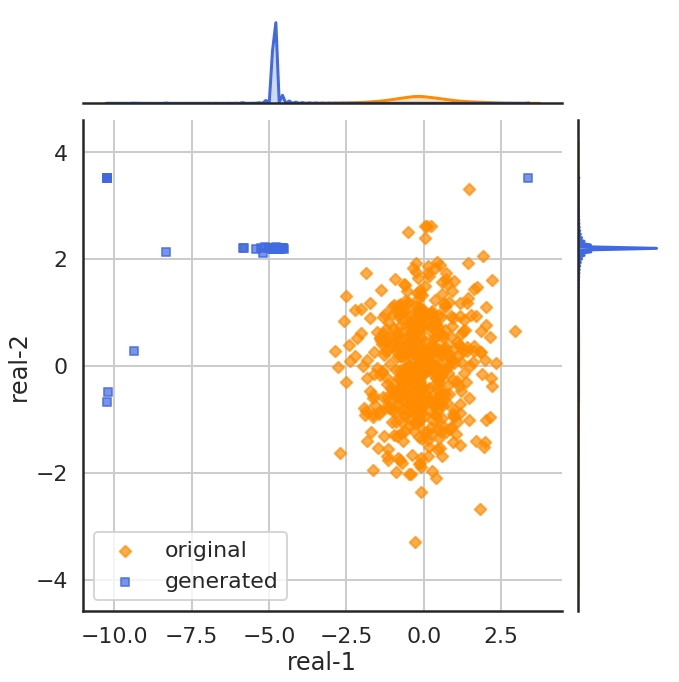

Case of rho = 0.2


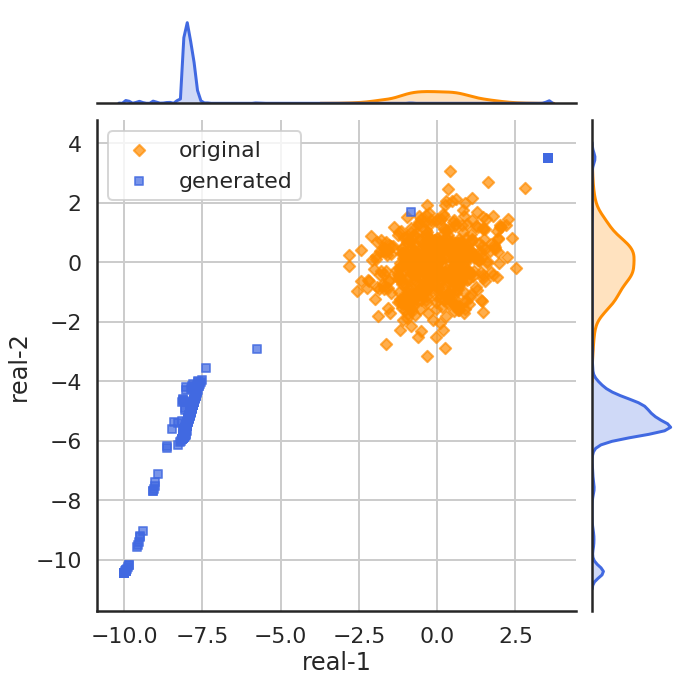

Case of rho = 0.30000000000000004


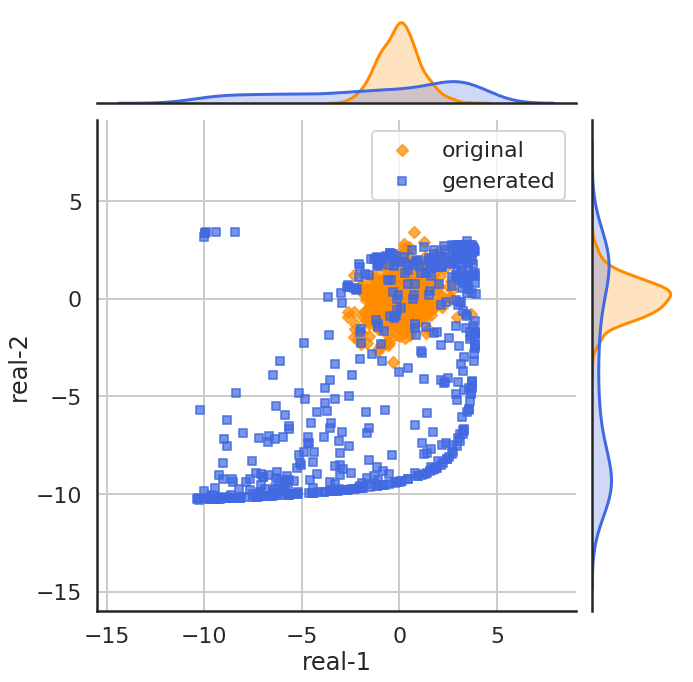

Case of rho = 0.4


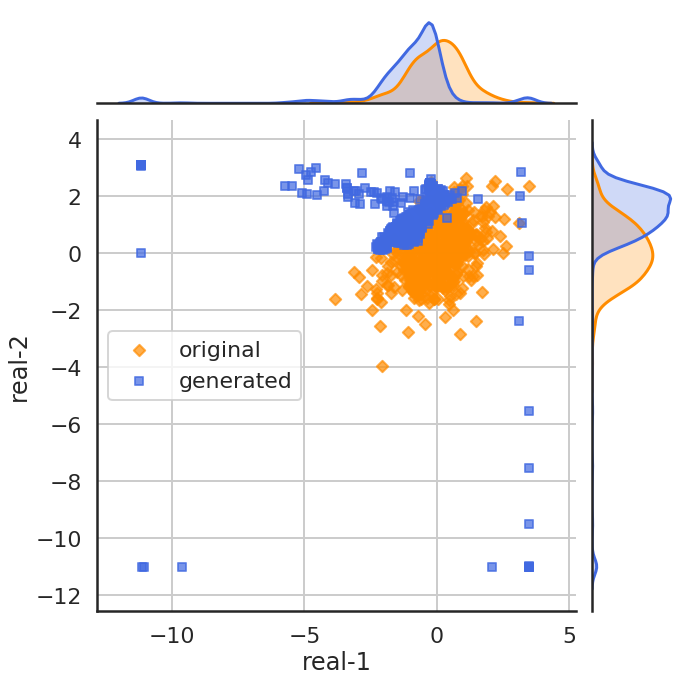

Case of rho = 0.5


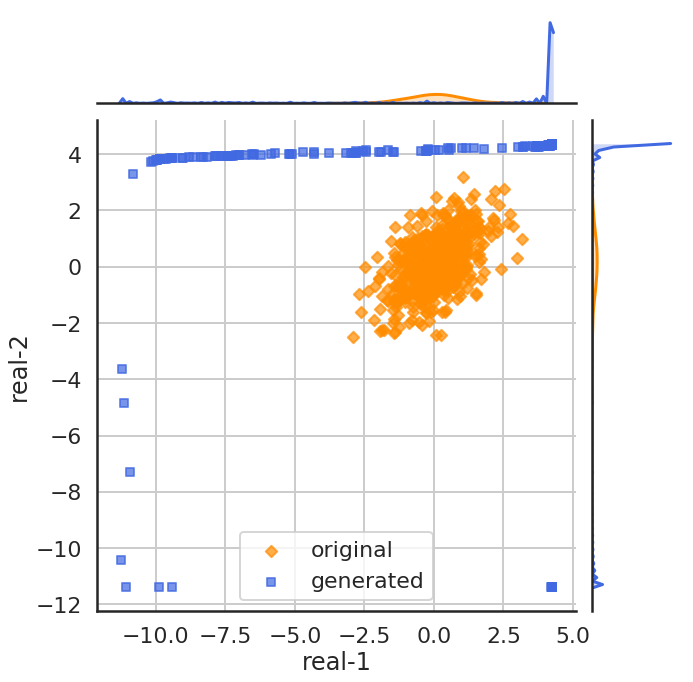

Case of rho = 0.6


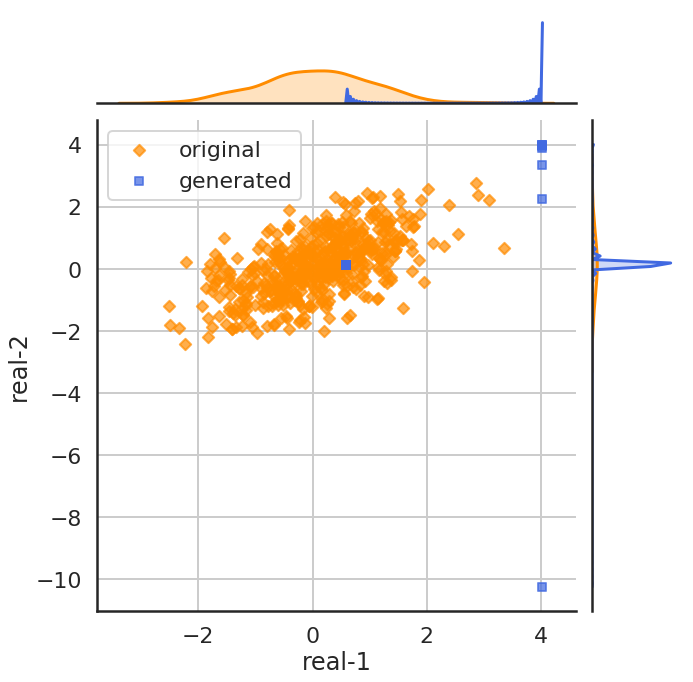

Case of rho = 0.7000000000000001


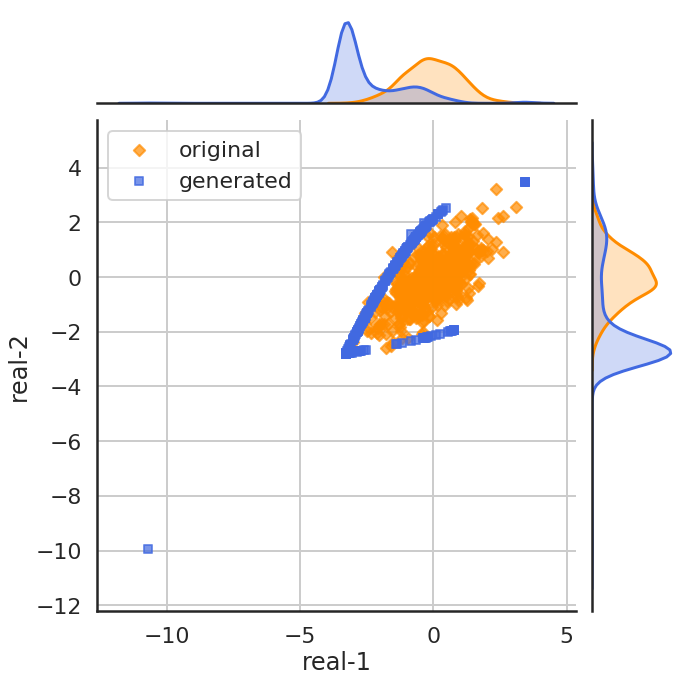

Case of rho = 0.8


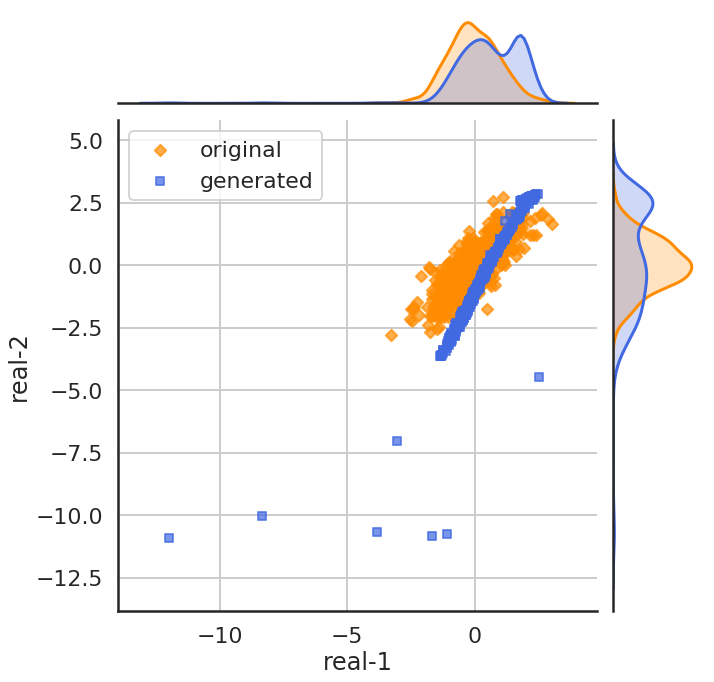

Case of rho = 0.9


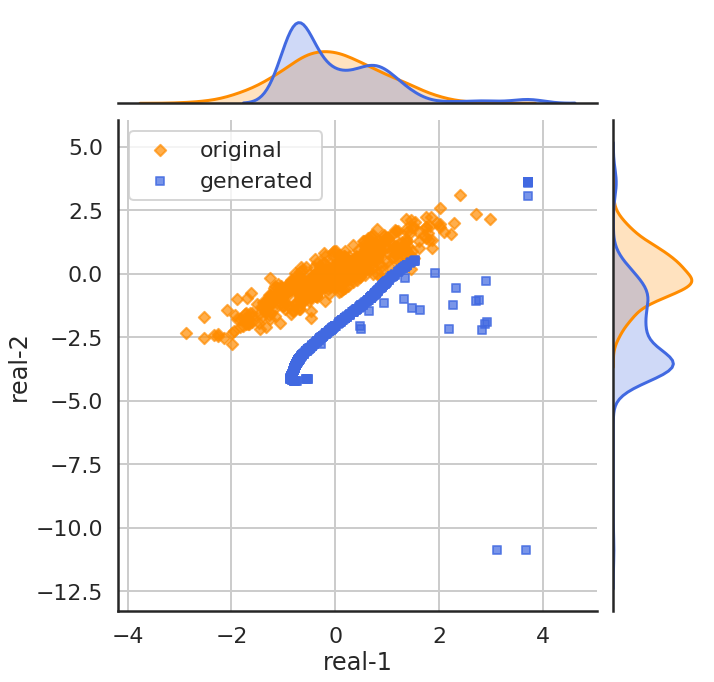

In [189]:
for key in original_dataset.keys():
    
    print("Case of rho = {}".format(original_dataset[key]['rho']))
    
    np.random.seed(0)
    indices = np.random.choice(5000, size=num_samples, replace=False)
    original = original_dataset[key]['data'][features].iloc[indices]
    generated = generated_dataset[key]['data'][features].iloc[indices]
    compare_original_and_generated(original, generated)

### Junk code [Trying phase]

In [72]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.7):

    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            kwargs['marker'] = '*'
            plt.scatter(*args, **kwargs)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x], df_group[col_y], color),
        )
        sns.kdeplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
            shade=True
        )
        sns.kdeplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,
            vertical=True,
            shade=True
        )

    plt.grid()
    plt.legend(legends)

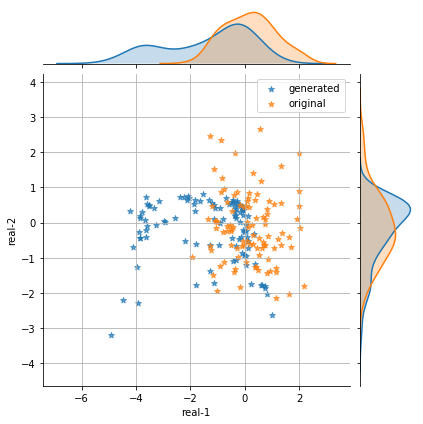

In [73]:
original['kind'] = 'original'
generated['kind'] = 'generated'
df=pd.concat([original, generated])
multivariateGrid('real-1', 'real-2', 'kind', df=df)